In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from db.connection import q

In [2]:
df = q('''
       SELECT 
           country_code,
           birth_date,
           risk_profile
       FROM public."Customer"
       WHERE deleted_at IS NULL
       ''')
df['birth_date'] = pd.to_datetime(df['birth_date'])
df.head()

,country_code,birth_date,risk_profile
0,US,1966-02-02,3
1,GB,1957-02-04,1
2,FR,1958-02-04,3
3,IN,1974-01-31,2
4,CA,2003-01-24,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   country_code  100 non-null    object        
 1   birth_date    100 non-null    datetime64[ns]
 2   risk_profile  100 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.5+ KB


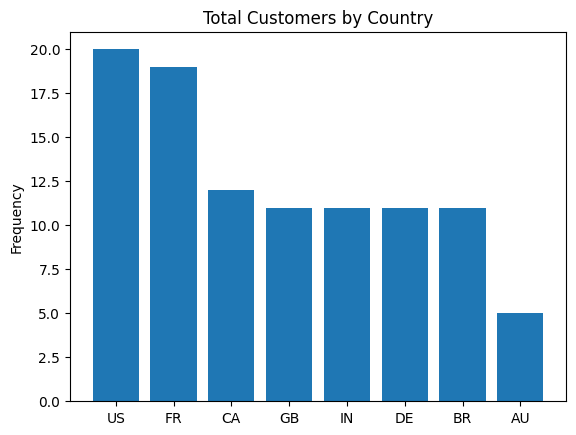

In [4]:
total_customer_by_country = df['country_code'].value_counts()

fig, ax = plt.subplots()
ax.bar(total_customer_by_country.index, total_customer_by_country.values)
ax.set_title('Total Customers by Country')
ax.set_ylabel('Frequency')

plt.show()

In [5]:
df[['country_code', 'risk_profile']].groupby(by='country_code', as_index=False).value_counts()

,country_code,risk_profile,count
0,AU,2,3
1,AU,1,1
2,AU,3,1
3,BR,1,7
4,BR,3,4
5,CA,3,7
6,CA,1,5
7,DE,1,5
8,DE,2,3
9,DE,3,3


In [6]:
df['risk_profile'].value_counts()

risk_profile
1    38
3    36
2    26
Name: count, dtype: int64

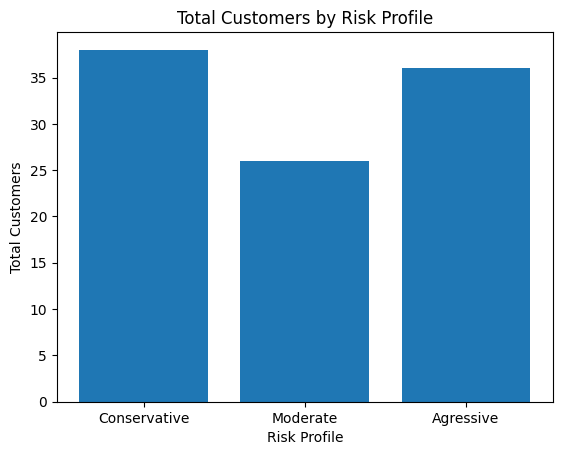

In [7]:
total_risk_profiles = df['risk_profile'].value_counts()

fig, ax = plt.subplots()
ax.bar(total_risk_profiles.index, total_risk_profiles.values)
ax.set_xticks([1, 2, 3], ['Conservative', 'Moderate', 'Agressive'])
ax.set_title('Total Customers by Risk Profile')
ax.set_xlabel('Risk Profile')
ax.set_ylabel('Total Customers')

plt.show()

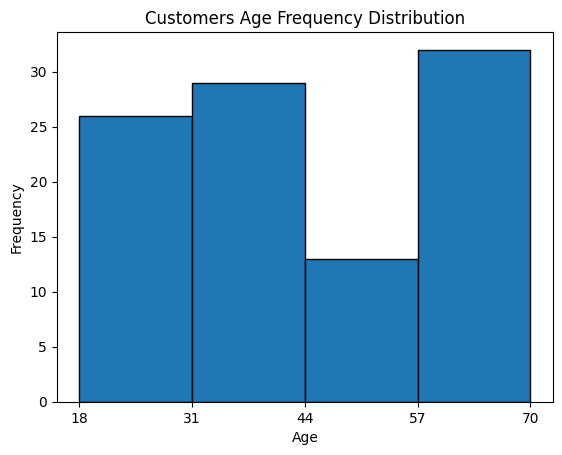

In [8]:
df['age'] = pd.Timestamp.today().year - df['birth_date'].dt.year
bins = np.histogram_bin_edges(df['age'], bins='fd')

fig, ax = plt.subplots()
ax.hist(df['age'], bins=bins, edgecolor='black')
ax.set_xticks(bins)
ax.set_title('Customers Age Frequency Distribution')
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')

plt.show()

In [9]:
df['age'].describe()

count    100.000000
mean      43.460000
std       16.367879
min       18.000000
25%       29.250000
50%       40.000000
75%       60.000000
max       70.000000
Name: age, dtype: float64

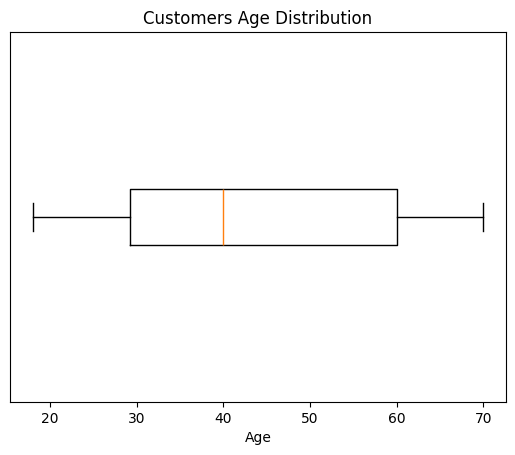

In [10]:
fig, ax = plt.subplots()
ax.boxplot(df['age'], orientation='horizontal')
ax.set_yticks([])
ax.set_xlabel('Age')
ax.set_title('Customers Age Distribution')

plt.show()